## 교차검증 & 샘플링 & 그리드 서치
- 정확하다->정확도를 올린다 (x)
- Accuracy Better Model (x)
- Accuracy Stable Model (o)

In [1]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')



### Input & Target로 1차 분리

In [2]:
data = wine[['alcohol','sugar','pH']].to_numpy()
target=wine['class'].to_numpy()

### 세트분리
- 기존) : train/test 세트로 분리했었음
- 지금) : train/vaild/test 세트로 분리

- train/test 8:2로 분리

In [3]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)

train_input.shape, test_input.shape, train_target.shape, test_target.shape

((5197, 3), (1300, 3), (5197,), (1300,))

In [4]:
from pandas.core.common import random_state
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

sub_input.shape, val_input.shape, sub_target.shape, val_target.shape

((4157, 3), (1040, 3), (4157,), (1040,))

- 그 전 까지는 모형 만들고, 모형 평가
 + 기존) test 데이터를 바로 평가 (unseen data) / 미래에 올 데이터
 + 지금) val 데이터만 평가 test데이터는 모형이 최종적으로 만들어졌다고 판단되면 그 때 평가

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))
# 과대적합 일어남 
# 0.9971133028626413
# 0.864423076923077

0.9971133028626413
0.864423076923077


## 교차검증을 해야 함

In [6]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)

print(scores)

{'fit_time': array([0.01357579, 0.0076828 , 0.0077703 , 0.00772238, 0.00733209]), 'score_time': array([0.00107765, 0.00093555, 0.00090718, 0.0009129 , 0.0009532 ]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [7]:
scores['test_score']
#샘플링 자체가 편향적이여서 점수가 제각각으로 나옴

array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])

In [8]:
import numpy as np

# 검증 데이터 점수
np.mean(scores['test_score'])

0.855300214703487

- StratifiedKFold 활용
 + 통계용어 : 층화추출 (비율에 근거해서 추출하기)
- 기존 방법 : 임의 추출 방식(무작위 방식)
- 분류 모형
 + 분류기준/레드와인의 갯수, 화이트와인 갯수 

In [9]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [10]:
# n_splits : 몇 번 교차검증 할건지 숫자 10
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼 파라미터의 개념
- 기존) 수동으로 조정해서 하나씩 값을 확인했었음
  - ridge, Lasso(), alpha값 조정
  - decision tree, max_depth 값 조정

- 지금) 자동화 개발 --> 머신러닝 엔지니어

In [11]:
from sklearn.model_selection import GridSearchCV

# 모형 만들기
dt = DecisionTreeClassifier(random_state=42)

#하이퍼 파라미터 투입
params = {'max_depth' : [2,3,4,5,6,7]}
gs=GridSearchCV(dt, params, n_jobs=1)

#모형 학습 --> 7번 수행
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7]})

- 가장 최적화된 max_depth 확인

In [12]:
print(gs.best_params_)
#5가 제일 좋음

{'max_depth': 5}


In [13]:
best_dt = gs.best_estimator_
print(best_dt.score(train_input, train_target))

0.8672310948624207


In [14]:
gs.cv_results_['mean_test_score']

result = pd.DataFrame({
    'max_depth':[2,3,4,5,6,7],
    'score' : gs.cv_results_['mean_test_score']
})

result

,max_depth,score
0,2,0.813936
1,3,0.841256
2,4,0.853378
3,5,0.857804
4,6,0.855880
5,7,0.855301


In [15]:
#하이퍼 파라미터 투입
params = {'max_depth' : [2,3,4,5,6,7],
          #노드 분할 시, 불순도 감소 최저량 지정
          'min_impurity_decrease': np.arange(0.0001, 0.001, 0.01),
          'min_samples_split': range(2, 100, 10)
          } 

gs=GridSearchCV(dt, params, n_jobs=1)

#모형 학습 --> 7번 수행
gs.fit(train_input, train_target)

print(gs.best_params_)

best_dt = gs.best_estimator_
print(best_dt.score(train_input, train_target))

#그리드 서치 끝

{'max_depth': 7, 'min_impurity_decrease': 0.0001, 'min_samples_split': 92}
0.8793534731575909


## 랜덤 서치
- 매개변수 값의 목록을 전달하는 것이 아님
- 매개변수가 샘플링하 수 있는 객체를 전달

In [16]:
from scipy.stats import uniform, randint

rgen = randint(0, 10)
np.unique(rgen.rvs(100), return_counts=True)
# 0은 몇개 ..

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 9,  7, 10,  8,  9, 13,  9, 13, 14,  8]))

- 실수 무작위 추출

In [17]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.3097427 , 0.9819341 , 0.05133061, 0.61734658, 0.42637152,
       0.38651877, 0.77542467, 0.28608657, 0.65167482, 0.25179314])

In [18]:
from sklearn.model_selection import RandomizedSearchCV

#하이퍼 파라미터 투입
params = {'max_depth' : randint(2, 50),
          #노드 분할 시, 불순도 감소 최저량 지정
          'min_impurity_decrease': uniform(0.0001, 0.1),
          'min_samples_split': randint(2, 50),
          'max_leaf_nodes': randint(2, 50)
          } 
#모형 만들기
dt = DecisionTreeClassifier(random_state=42)

#랜덤 서치
rs = RandomizedSearchCV(dt, params, n_iter=100, random_state=42, n_jobs=-1)

rs.fit(train_input, train_target)


RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96d8b43710>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96d8b653d0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96d8b43550>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f96d8b2a790>},
                   random_state=42)

In [19]:
print(rs.best_params_)

best_dt = rs.best_estimator_
print(best_dt.score(train_input, train_target))
#그리스 서치보다 나은 결과가 나옴

{'max_depth': 29, 'max_leaf_nodes': 27, 'min_impurity_decrease': 0.002635074341545751, 'min_samples_split': 24}
0.8647296517221474


## 주요 정리
- 샘플링 중요 : 데이터가 편향적일 수 있다. 
- 과대적합 방지 : 하이퍼파라미터 퓨닝을 진행한다.
  + 그리드 서치 : 비추천
  + 랜덤 서치 : 추천
  + 각 모델의 도움말을 잘 살펴본다

## 오후수업
- 트리의 앙상블 또는 다양한 트리 관련 모델 입문


## 랜덤포레스트(Random Forest)
- Decision Tree 
- 데이터 샘플은 무작위로 뽑는다(행 조정)
- 데이터 컬럼 갯수가 매우 많음
  + 1천개
  + 컬럼 갯수의 조합 (무작위 선택 필요)
  + 독립된 모형
- 데이터 셋이 클 때 매우 큰 효과를 발휘한다.


In [21]:
train_input.shape, test_input.shape, train_target.shape, test_target.shape

((5197, 3), (1300, 3), (5197,), (1300,))

In [24]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [25]:
scores

{'fit_time': array([2.43386698, 0.4787035 , 0.45695257, 0.4658494 , 0.44879174]),
 'score_time': array([0.1049242 , 0.10345054, 0.10318589, 0.10301328, 0.10383081]),
 'test_score': array([0.88461538, 0.88942308, 0.90279115, 0.88931665, 0.88642926]),
 'train_score': array([0.9971133 , 0.99663219, 0.9978355 , 0.9973545 , 0.9978355 ])}

### 특성 중요도
- 각 데이터의 특성(feature)이 존재
- 현재 사용하는 알고리즘에서 중요도를 표시해주는 것

In [26]:
rf.fit(train_input, train_target)

# 
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


- 알코올      당도       pH
- [0.23167441 0.50039841 0.26792718]

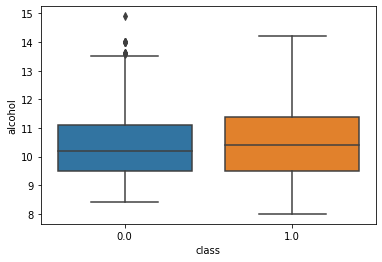

In [30]:
import seaborn as sns

# sns.scatterplot(data = wine, x = 'pH', y= 'sugar', hue='class')
sns.boxplot(data=wine, x='class', y='alcohol')

- 복원 추출
  + 한 번도 추출이 안 된 샘플이 있을 수 있음

In [33]:
rf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_) #검증 세트와 비슷한 느낌임
print(rf.score(train_input, train_target))
print(rf.score(test_input, test_target))

0.8934000384837406
0.996921300750433
0.8892307692307693


## 확률적 경사하강법
- 점진적 학습
  + 대표 알고리즘 : 확률적 경사 하강법(Stochastic Gradient Descent)
  + 확률적 : 무작위 데이터
- 훈련세트 분리
  + 샘플 뽑기
    + 확률적 경사하강법 1개씩 뽑기
    + 미니배치 경사 하강법 : 여러 개씩 뽑기
    + 배치 경사 하강법 : 몽땅 꺼내기
  + 조금씩 경사 및 기울기를 따라 이동
  + 모든 훈련 세트 소진 : 1 에포크 끝

- 손실함수(loss function)
 + 머신러닝 알고리즘이 얼마나 잘 못맞추느냐 측정하는 기준
 + 손실 함수의 값은 작을수록 좋다



## 그레이디언트 부스팅
- 처음에 샘플을 뽑고, 경사하강법을 적용
  + 사용하는 모델은 결정 트리
  

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=500,
                                learning_rate=0.2,
                                subsample=0.5, #전체 훈련 세트
                                random_state=42)

scores = cross_validate(gb, train_input, train_target,
                        return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9434289514154802 0.8751230843266453


## XGBoost s LightGBM
- Decision Tree
- 노드가 분기 시, 속도 차이 존재
  + LigBGM > XGBoost
- GPU 지원 여부
  + 기존) 선형회귀, 결정트리, 랜덤포레스트, 일반 부스팅 (X)
  + XGBoost, LightGBM (o)
- 공통적인 특징(문법상 미세한 차이 발생)
  + Scikit-Learn과 연동된 API
  + 독자적인 API
  + 약간의 문법적인 혼동이 옴

## Scikit-Learn API

In [38]:
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8824322471423747 0.8726214185237284


In [41]:
import xgboost as xgb

# read in data
dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

# specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2

bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

XGBoostError: ignored

In [40]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9338079582727165 0.8789710890649293


머신러닝 프로세스
- 데이터 수집
- 데이터 전처리
  + Feature Engineering 했음 (표준화), 각 수치 데이터의 단위가 달라서 
- 머신러닝 모델
  + 분류 
  + 회귀(수치예측)
  + KNN, 선형회귀, 로지스틱회귀, 결정트리(랜덤포레스트 등), 경사하강법
- 하이퍼 파라미터, 교차검증
  + 그리드 서치
  + 랜덤 서치
- 평가지표(시간관계상 디테일하게 못 함)
  + 분류 : 정확도
  + 회귀 : MAE